In [106]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch.utils.data import DataLoader, Dataset
from albumentations.pytorch.transforms import ToTensorV2
import albumentations
import torch
import os, cv2
import numpy as np

dataset_dir = '../dataset'
train_coco = COCO(os.path.join(dataset_dir, 'train.json'))
test_coco = COCO(os.path.join(dataset_dir, 'test.json'))

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [123]:
class CustomDataset(Dataset):
    '''
      data_dir: data가 존재하는 폴더 경로
      transforms: data transform (resize, crop, Totensor, etc,,,)
    '''

    def __init__(self, annotation, data_dir, transforms=None):
        super().__init__()
        self.data_dir = data_dir
        self.coco = COCO(annotation)
        self.predictions = {
            "images": self.coco.dataset["images"].copy(),
            "categories": self.coco.dataset["categories"].copy(),
            "annotations": None
        }
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.coco.getImgIds(imgIds=index)

        image_info = self.coco.loadImgs(image_id)[0]

        image = cv2.imread(os.path.join(self.data_dir, image_info['file_name']))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        ann_ids = self.coco.getAnnIds(imgIds=image_info['id'])
        anns = self.coco.loadAnns(ann_ids)

        boxes = np.array([x['bbox'] for x in anns])

        # boxex (x_min, y_min, x_max, y_max)
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]

        # torchvision faster_rcnn은 label=0을 background로 취급
        # class_id를 1~10으로 수정
        labels = np.array([x['category_id'] for x in anns])
        labels = torch.as_tensor(labels, dtype=torch.int64)

        areas = np.array([x['area'] for x in anns])
        areas = torch.as_tensor(areas, dtype=torch.float32)

        is_crowds = np.array([x['iscrowd'] for x in anns])
        is_crowds = torch.as_tensor(is_crowds, dtype=torch.int64)

        target = {'boxes': boxes, 'labels': labels, 'image_id': torch.tensor([index]), 'area': areas,
                  'iscrowd': is_crowds}

        # transform
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            target['boxes'] = torch.tensor(sample['bboxes'], dtype=torch.float32)

        return image, target, image_id

    def __len__(self) -> int:
        return len(self.coco.getImgIds())

In [126]:
def get_train_transform():
    return albumentations.Compose([
        albumentations.Resize(1024, 1024),
        albumentations.Flip(p=0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [127]:
ds = CustomDataset(os.path.join(dataset_dir, 'train.json'), dataset_dir, transforms=get_train_transform())
image, target, image_id = ds[5]

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


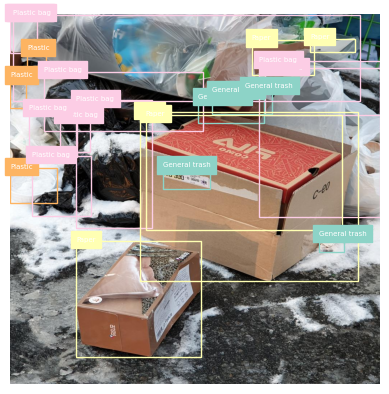

In [128]:

img = image.cpu().numpy().transpose(1,2,0)
img = (img * 255).astype(np.uint8)
fig, ax = plt.subplots(1)

colors = {}
for i, label in enumerate(target['labels']):
    category_name = train_coco.loadCats(int(label))[0]['name']

    if category_name not in colors:
        colors[category_name] = plt.get_cmap('Set3')(label)

    x_min, y_min, x_max, y_max = target['boxes'][i]
    
    edgecolor = colors[category_name]
    rect = patches.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, linewidth=1, edgecolor=edgecolor, facecolor='none')
    ax.add_patch(rect)
    ax.text(x_min, y_min, category_name, color='white', fontsize=5, backgroundcolor=edgecolor)

plt.axis('off')
ax.imshow(img)

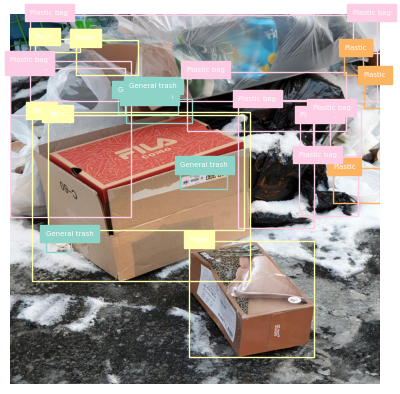

In [26]:
img_id   = train_coco.getImgIds(imgIds=5)  # 여기 id만 수정해서 사용 
img_info = train_coco.loadImgs(img_id)[0]
ann_id   = train_coco.getAnnIds(imgIds=img_id)
anns     = train_coco.loadAnns(ann_id)

img = cv2.imread(os.path.join(dataset_dir, img_info['file_name']))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(float)
img /= 255.0

fig, ax = plt.subplots(1)

colors = {}
for ann in anns:
    category_id   = ann['category_id']
    category_name = train_coco.loadCats(category_id)[0]['name']

    if category_name not in colors:
        colors[category_name] = plt.get_cmap('Set3')(category_id)

    x, y, w, h = ann['bbox']
    
    edgecolor = colors[category_name]
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor=edgecolor, facecolor='none')
    ax.add_patch(rect)
    ax.text(x, y, category_name, color='white', fontsize=5, backgroundcolor=edgecolor)

plt.axis('off')
ax.imshow(img)

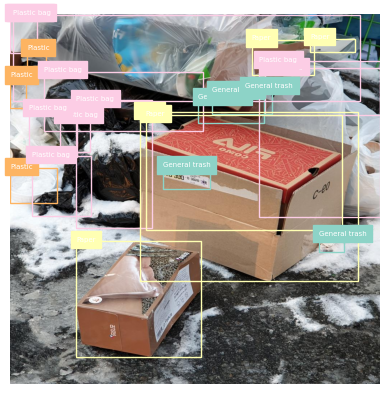

In [59]:
import albumentations

transform = albumentations.Compose(
    [
        albumentations.HorizontalFlip(p=1)
    ], 
    bbox_params=albumentations.BboxParams(format='coco')
)

img_id   = train_coco.getImgIds(imgIds=5)  # 여기 id만 수정해서 사용 
img_info = train_coco.loadImgs(img_id)[0]
ann_id   = train_coco.getAnnIds(imgIds=img_id)
anns     = train_coco.loadAnns(ann_id)

img = cv2.imread(os.path.join(dataset_dir, img_info['file_name']))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(float)
img /= 255.0

def visualize_bbox(ax, x, y, w, h, category_name, colors):
    edgecolor = colors[category_name]
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor=edgecolor, facecolor='none')
    ax.add_patch(rect)
    ax.text(x, y, category_name, color='white', fontsize=5, backgroundcolor=edgecolor)
    return ax

fig, ax = plt.subplots(1)
is_train = True
bboxes = []
colors = {}
for ann in anns:
    x, y, w, h    = ann['bbox']
    category_id   = ann['category_id']
    category_name = train_coco.loadCats(category_id)[0]['name']
    
    if is_train == True:
        bboxes.append([x, y, w, h, category_name])

    if category_name not in colors:
        colors[category_name] = plt.get_cmap('Set3')(category_id)
    
transform1 = transform(image=img, bboxes=bboxes)
transform1_image = transform1['image']
transform1_bboxes = transform1['bboxes']

for bbox in transform1_bboxes:
    x, y, w, h    = bbox[0], bbox[1], bbox[2], bbox[3]
    category_name = bbox[4]
    ax = visualize_bbox(ax, x, y,w, h, category_name, colors)

plt.axis('off')
ax.imshow(transform1_image)

In [ ]:
# TO DO 1 : 여러 개 파이프라인 구축
# TO DO 2 : 여러 개의 이미지에 대해서 동작하게끔 작성
# TO DO 3 : MOSAIC 구현
# TO DO 4 : 리팩토링으로 정리